# TSMixer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

class DataLoader:

  def __init__(self, batch_size, seq_len, pred_len):
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.target_slice = slice(0, None)

    self._read_data()

  def _read_data(self):

    filepath = ('data/ETTh1_original.csv')

    df_raw = pd.read_csv(filepath)
    df = df_raw.set_index('date')

    # split train/valid/test
    n = len(df)
    train_end = int(n * 0.7)
    val_end = n - int(n * 0.2)
    test_end = n

    train_df = df[:train_end]
    val_df = df[train_end - self.seq_len : val_end]
    test_df = df[val_end - self.seq_len : test_end]

    # standardize by training set
    self.scaler = StandardScaler()
    self.scaler.fit(train_df.values)

    def scale_df(df, scaler):
      data = scaler.transform(df.values)
      return pd.DataFrame(data, index=df.index, columns=df.columns)

    self.train_df = scale_df(train_df, self.scaler)
    self.val_df = scale_df(val_df, self.scaler)
    self.test_df = scale_df(test_df, self.scaler)
    self.n_feature = self.train_df.shape[-1]

  def _split_window(self, data):
    inputs = data[:, : self.seq_len, :]
    labels = data[:, self.seq_len :, self.target_slice]

    inputs.set_shape([None, self.seq_len, None])
    labels.set_shape([None, self.pred_len, None])
    return inputs, labels

  def _make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=(self.seq_len + self.pred_len),
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=self.batch_size,
    )
    ds = ds.map(self._split_window)
    return ds

  def inverse_transform(self, data):
    return self.scaler.inverse_transform(data)

  def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)

  def get_val(self):
    return self._make_dataset(self.val_df, shuffle=False)

  def get_test(self):
    return self._make_dataset(self.test_df, shuffle=False)

In [3]:
data_loader = DataLoader(batch_size=32, seq_len=512, pred_len=96)

train_data = data_loader.get_train()
val_data = data_loader.get_val()
test_data = data_loader.get_test()

In [4]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.BatchNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.7)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.7)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.7)(x)
  return x + res

In [5]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)

In [6]:
model = build_model(
    input_shape=(512, data_loader.n_feature),
    pred_len=96,
    n_block=8,
    ff_dim=64,
    target_slice=data_loader.target_slice
)

In [7]:
import time

tf.keras.utils.set_random_seed(42)

optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer, loss='mse', metrics=['mae'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tsmixer_checkpoints/',
    vebose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

start_training_time = time.time()

history = model.fit(
    train_data,
    epochs= 30,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stop_callback]
)

end_training_time = time.time()
elasped_training_time = end_training_time - start_training_time
print(f'Training finished in {elasped_training_time} secconds')

Epoch 1/30
363/363 [==============================] - 54s 126ms/step - loss: 27.9493 - mae: 4.0994 - val_loss: 0.9159 - val_mae: 0.7489
Epoch 2/30
363/363 [==============================] - 46s 126ms/step - loss: 11.3880 - mae: 2.6455 - val_loss: 0.7342 - val_mae: 0.6692
Epoch 3/30
363/363 [==============================] - 45s 124ms/step - loss: 6.5457 - mae: 2.0049 - val_loss: 0.6726 - val_mae: 0.6389
Epoch 4/30
363/363 [==============================] - 44s 122ms/step - loss: 4.3104 - mae: 1.6230 - val_loss: 0.6248 - val_mae: 0.6115
Epoch 5/30
363/363 [==============================] - 44s 122ms/step - loss: 3.0450 - mae: 1.3605 - val_loss: 0.5863 - val_mae: 0.5883
Epoch 6/30
363/363 [==============================] - 44s 121ms/step - loss: 2.2560 - mae: 1.1672 - val_loss: 0.5508 - val_mae: 0.5640
Epoch 7/30
363/363 [==============================] - 46s 128ms/step - loss: 1.7369 - mae: 1.0203 - val_loss: 0.5205 - val_mae: 0.5423
Epoch 8/30
363/363 [==============================] -

In [8]:
best_epoch = np.argmin(history.history['val_loss'])

model.load_weights("tsmixer_checkpoints/")

In [9]:
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

106/106 [==============================] - 3s 25ms/step


(96, 7)

In [10]:
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

preds = data_loader.inverse_transform(scaled_preds)

preds_df = pd.DataFrame(preds)
preds_df.columns = cols

preds_df.to_csv('data/tsmixer_preds_etth1_h96.csv', index=False, header=True)
scaled_preds_df.to_csv('data/tsmixer_scaled_preds_etth1_h96.csv', index=False, header=True)

In [11]:
preds_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,9.783643,1.828940,6.611066,0.410760,2.775144,0.976482,6.176808
1,10.346516,1.945308,7.340568,0.546736,2.691021,0.944694,5.647042
2,11.133471,2.252884,7.656474,0.728890,2.738519,0.992854,5.419943
3,11.133713,2.657871,7.635908,0.993395,2.916682,1.051881,5.555630
4,12.121804,3.026586,8.378697,1.277050,3.137067,1.118916,5.940153


In [12]:
scaled_preds_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.368250,-0.060601,0.334844,-0.146730,-0.118572,0.295890,-1.211947
1,0.456878,-0.005528,0.453329,-0.076186,-0.189350,0.247901,-1.275404
2,0.580789,0.140036,0.504638,0.018313,-0.149387,0.320605,-1.302606
3,0.580827,0.331701,0.501298,0.155535,0.000512,0.409713,-1.286353
4,0.736408,0.506200,0.621941,0.302692,0.185933,0.510911,-1.240294


## N-HiTS 

In [8]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [9]:
df = pd.read_csv('data/ETTh1_original.csv')
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [10]:
columns_to_melt = ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

melted_df = df.melt(id_vars=['date'], value_vars=columns_to_melt, var_name='unique_id', value_name='y')

melted_df.rename(columns={'date': 'ds'}, inplace=True)

melted_df['ds'] = pd.to_datetime(melted_df['ds'])

melted_df.head()

,ds,unique_id,y
0,2016-07-01 00:00:00,HUFL,5.827
1,2016-07-01 01:00:00,HUFL,5.693
2,2016-07-01 02:00:00,HUFL,5.157
3,2016-07-01 03:00:00,HUFL,5.090
4,2016-07-01 04:00:00,HUFL,5.358


In [11]:
horizon = 96

models = [
    NHITS(h=horizon, input_size=512, max_steps=30),
]

Global seed set to 1


In [12]:
nf = NeuralForecast(models=models, freq='H')

In [13]:
n_preds_df = nf.cross_validation(df=melted_df, val_size=int(0.2*len(df)), test_size=int(0.1*len(df)), n_windows=None)

Epoch 29: 100%|█████████████████| 1/1 [00:00<00:00,  2.92it/s, v_num=98, train_loss_step=1.910, train_loss_epoch=1.930]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 29: 100%|█| 1/1 [00:01<00:00,  1.28s/it, v_num=98, train_loss_step=1.910, train_loss_epoch=1.930, valid_loss=2.22
Epoch 29: 100%|█| 1/1 [00:01<00:00,  1.29s/it, v_num=98, train_loss_step=1.910, train_loss_epoch=1.910, valid_loss=2.22
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


In [14]:
n_preds_df.head()

,unique_id,ds,cutoff,NHITS,y
0,HUFL,2018-04-15 06:00:00,2018-04-15 05:00:00,13.136290,15.874
1,HUFL,2018-04-15 07:00:00,2018-04-15 05:00:00,11.774220,13.128
2,HUFL,2018-04-15 08:00:00,2018-04-15 05:00:00,8.583214,3.148
3,HUFL,2018-04-15 09:00:00,2018-04-15 05:00:00,5.306442,-5.693
4,HUFL,2018-04-15 10:00:00,2018-04-15 05:00:00,1.011492,-10.784


In [15]:
df['date'][-96:] = pd.to_datetime(df['date'][-96:])

max_date = df['date'][-96:].max()
min_date = df['date'][-96:].min()

print(min_date, max_date)

2018-06-22 20:00:00 2018-06-26 19:00:00


In [16]:
last_n_preds_df = n_preds_df[(n_preds_df['ds'] >= min_date) & (n_preds_df['ds'] <= max_date)]

last_n_preds_df

,unique_id,ds,cutoff,NHITS,y
148991,HUFL,2018-06-22 20:00:00,2018-06-18 20:00:00,10.835604,6.564
149086,HUFL,2018-06-22 20:00:00,2018-06-18 21:00:00,12.152081,6.564
149087,HUFL,2018-06-22 21:00:00,2018-06-18 21:00:00,12.602386,6.564
149181,HUFL,2018-06-22 20:00:00,2018-06-18 22:00:00,10.489227,6.564
149182,HUFL,2018-06-22 21:00:00,2018-06-18 22:00:00,11.020892,6.564
...,...,...,...,...,...
1106779,OT,2018-06-26 15:00:00,2018-06-22 19:00:00,6.169090,10.904
1106780,OT,2018-06-26 16:00:00,2018-06-22 19:00:00,5.907017,11.044
1106781,OT,2018-06-26 17:00:00,2018-06-22 19:00:00,5.559777,10.271
1106782,OT,2018-06-26 18:00:00,2018-06-22 19:00:00,5.709448,9.778


In [17]:
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

clean_last_n_preds_df = pd.DataFrame()

for col in cols:
    temp_df = last_n_preds_df[last_n_preds_df['unique_id'] == col].drop_duplicates(subset='ds', keep='first')
    clean_last_n_preds_df = pd.concat([clean_last_n_preds_df, temp_df], ignore_index=True)

In [18]:
clean_last_n_preds_df

,unique_id,ds,cutoff,NHITS,y
0,HUFL,2018-06-22 20:00:00,2018-06-18 20:00:00,10.835604,6.564000
1,HUFL,2018-06-22 21:00:00,2018-06-18 21:00:00,12.602386,6.564000
2,HUFL,2018-06-22 22:00:00,2018-06-18 22:00:00,11.378361,9.042000
3,HUFL,2018-06-22 23:00:00,2018-06-18 23:00:00,12.418781,11.119000
4,HUFL,2018-06-23 00:00:00,2018-06-19 00:00:00,11.536001,16.476999
...,...,...,...,...,...
667,OT,2018-06-26 15:00:00,2018-06-22 15:00:00,4.331094,10.904000
668,OT,2018-06-26 16:00:00,2018-06-22 16:00:00,5.626397,11.044000
669,OT,2018-06-26 17:00:00,2018-06-22 17:00:00,4.128483,10.271000
670,OT,2018-06-26 18:00:00,2018-06-22 18:00:00,4.590957,9.778000


In [20]:
clean_last_n_preds_df.to_csv('data/nhits_preds_etth1_h96.csv', index=False, header=True)

## Evaluation 

In [48]:
nhits_preds = pd.read_csv('data/nhits_preds_etth1_h96.csv')
tsmixer_preds = pd.read_csv('data/tsmixer_preds_etth1_h96.csv')

In [50]:
tsmixer_preds

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,9.783643,1.828940,6.611066,0.410760,2.775144,0.976482,6.176808
1,10.346516,1.945308,7.340568,0.546736,2.691021,0.944694,5.647042
2,11.133471,2.252884,7.656474,0.728890,2.738519,0.992854,5.419943
3,11.133713,2.657872,7.635908,0.993395,2.916682,1.051881,5.555630
4,12.121804,3.026586,8.378697,1.277050,3.137067,1.118916,5.940153
...,...,...,...,...,...,...,...
91,-3.986025,2.388264,-6.330092,0.850562,2.652524,1.100195,9.882478
92,-0.081644,2.174035,-2.532439,0.653812,2.748767,1.120828,9.157974
93,3.744680,1.827072,0.932927,0.433281,2.677535,1.053055,8.265033
94,6.322721,1.712198,3.394067,0.318376,2.642339,1.019517,7.820487


In [51]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


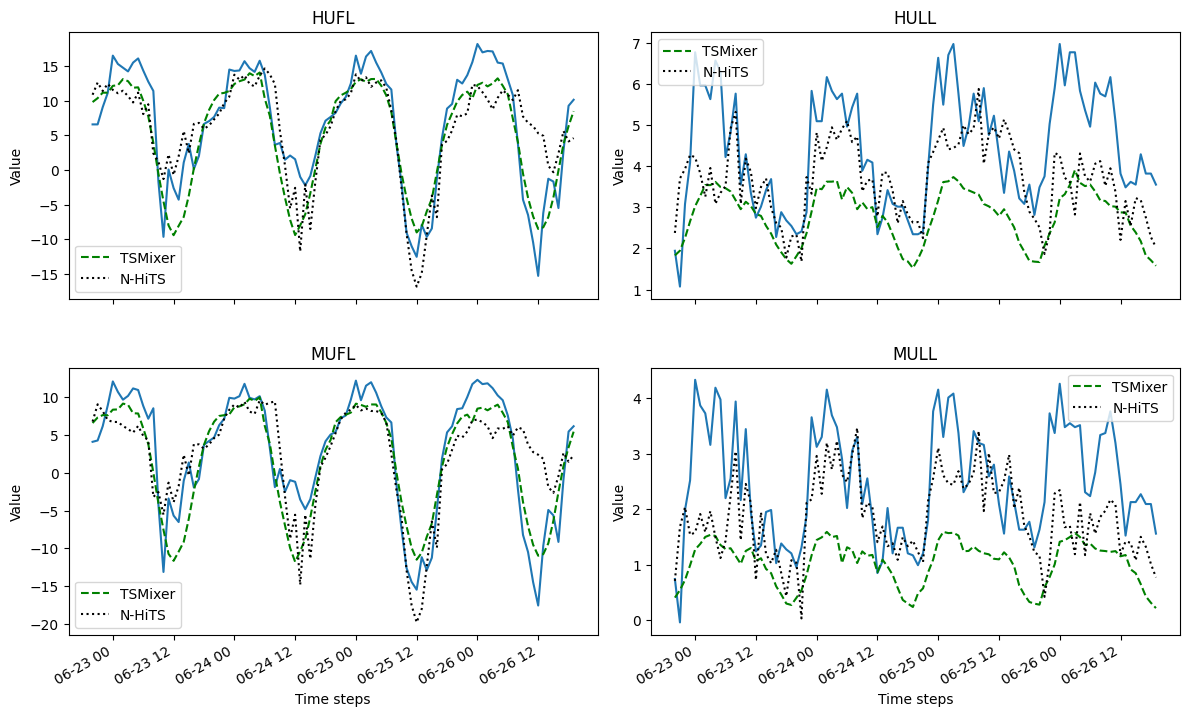

In [47]:
cols_to_plot = ['HUFL', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
    
    nhits_df = nhits_preds[nhits_preds['unique_id'] == col] 
    
    ax.plot(df['date'][-96:], df[col][-96:])
    ax.plot(df['date'][-96:], tsmixer_preds[col], label='TSMixer', ls='--', color='green')
    ax.plot(df['date'][-96:], nhits_df['NHITS'], label='N-HiTS', ls=':', color='black')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_actual = df.drop('date', axis=1)[-96:]

data = {'N-HiTS': 
            [mean_absolute_error(nhits_preds['y'], nhits_preds['NHITS']), 
             mean_squared_error(nhits_preds['y'], nhits_preds['NHITS'])],
       'TSMixer': 
            [mean_absolute_error(y_actual, tsmixer_preds), 
             mean_squared_error(y_actual, tsmixer_preds)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,TSMixer
mae,1.864861,1.611139
mse,10.093577,5.231349
